# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction, PtOnlyPreprocessing
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector
from fad.models.NNs import MLP_wrapper

# Import VAE training components
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from fad.models.VAE_paper.models import dense_vae, VAE, Sampling
from fad.models.VAE_paper.losses import make_kl

2025-07-28 16:21:46.659078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 16:21:46.759121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753712506.797429   43793 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753712506.808774   43793 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753712506.889860   43793 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import hls4ml

## 1. Data Loading and Exploration

In [3]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3500000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

path_anom3 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/hToTauTau_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset3 = _load_h5_challenge_dataset(
    path_bkg, path_anom3, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset3.train.shape}")
print(f"Test set shape: {dataset3.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset3.test_labels)}")

path_anom4 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/hChToTauNu_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset4 = _load_h5_challenge_dataset(
    path_bkg, path_anom4, n_train=100000, n_test=400000
)
# Print dataset information
print(f"Training set shape: {dataset4.train.shape}")
print(f"Test set shape: {dataset4.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset4.test_labels)}")


Loading datasets...
Discarding type index, shape bkg: (3560000, 19, 3), shape anom: (55969, 19, 3)
Discarding type index, shape bkg: (3560000, 19, 3), shape anom: (55969, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (115969, 57)
Number of anomalies in test set: 55969.0
Loading datasets...
Training set shape: (3500000, 57)
Test set shape: (115969, 57)
Number of anomalies in test set: 55969.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (340544, 19, 3)
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (340544, 19, 3)
Training set shape: (100000, 57)
Test set shape: (740544, 57)
Number of anomalies in test set: 340544.0
Loading datasets...
Training set shape: (100000, 57)
Test set shape: (740544, 57)
Number of anomalies in test set: 340544.0
Loading datasets...
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (400000, 19, 3)
Discarding type index, shape bkg: (500000, 19, 3), shape anom: (400000, 19, 3)
Training s

In [4]:
pts = dataset.train[:,::3]

## 2. Data Preprocessing

In [5]:
# preprocessor = Preprocessor([PtOnlyPreprocessing(new_padding_value=0)])
# X_train = preprocessor.transform(dataset.train, fit=True)
# # X_train[X_train == 0] = -11  # Replace padding with a negative value

# X_test = preprocessor.transform(dataset.test, fit=False)
# # X_test[X_test == 0] = -11  # Replace padding with a negative value

# X_test2 = preprocessor.transform(dataset2.test, fit=False)
# # X_test2[X_test2 == 0] = -11  # Replace padding with a negative value    
# X_test3 = preprocessor.transform(dataset3.test, fit=False)
# # X_test3[X_test3 == 0] = -11  # Replace padding with a negative value    
# X_test4 = preprocessor.transform(dataset4.test, fit=False)
# # X_test4[X_test4 == 0] = -11  # Replace padding with a negative value

In [4]:
# Preprocess data with standardization
# print("Preprocessing data...")
# preprocessor = Preprocessor([StandardScalerFunction()])
# # dataset.train[dataset.train==0] = np.nan
# X_train = preprocessor.transform(dataset.train, fit=True)
# # X_train[X_train==np.nan] = 0
# X_test = preprocessor.transform(dataset.test)
# print("Done")
# X_test2 = preprocessor.transform(dataset2.test)
# X_test3 = preprocessor.transform(dataset3.test)
# X_test4 = preprocessor.transform(dataset4.test)
X_train = dataset.train
X_test = dataset.test
X_test2 = dataset2.test
X_test3 = dataset3.test
X_test4 = dataset4.test


## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [5]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [8]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

# for dataset2
iso_scores2 = iso_forest.predict(X_test2)
iso_auc2 = roc_auc_score(dataset2.test_labels, iso_scores2)
iso_ap2 = average_precision_score(dataset2.test_labels, iso_scores2)
iso_accuracy2 = accuracy_score(dataset2.test_labels, iso_scores2 < 0)
print(f"Accuracy: {iso_accuracy2:.4f}")
print(f"AUC-ROC: {iso_auc2:.4f}")
print(f"Average Precision: {iso_ap2:.4f}")


results["Isolation Forest"] = {
    "scores": iso_scores,
    "auc": iso_auc,
    "ap": iso_ap,
    "time": iso_time,
}

Training Isolation Forest...
Training time: 12.29 seconds
Accuracy: 0.4187
AUC-ROC: 0.8688
Average Precision: 0.8478
Accuracy: 0.4129
AUC-ROC: 0.8457
Average Precision: 0.8003


In [9]:
print(X_train.shape[1])

57


### 4.2 Flow Matching

In [10]:
# config_path = "../fad/models/configs/flow_matching.yaml"
# with open(config_path, "r") as f:
#     config = yaml.safe_load(f)
# flow_matching = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size=config["batch_size"],
#     reflow_steps=config["reflow_steps"],
#     reflow_batches=config["reflow_batches"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.load("last_model.pt")

print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    #list_dims=[32, 32],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
    alpha=config["alpha"],
)
flow_matching.fit(X_train, mode="OT", reflow=False, eval_epochs=[-1], ignore_zeros_in_loss=False)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")
print(f"Number of parameters in the model:{sum(p.numel() for p in flow_matching.vf.parameters() if p.requires_grad)}")

Training Flow Matching (this may take a while)...
| iter      1 | 2737.98 ms/step | loss    5.828 
| iter      2 | 4644.70 ms/step | loss    6.174 
| iter      3 | 4628.64 ms/step | loss    5.108 
| iter      4 | 4771.37 ms/step | loss    3.850 
| iter      5 | 4900.13 ms/step | loss    3.395 
| iter      6 | 9137.40 ms/step | loss    4.218 
| iter      7 | 12391.46 ms/step | loss    4.588 
| iter      8 | 10350.77 ms/step | loss    4.836 
| iter      9 | 11296.72 ms/step | loss    4.180 
| iter     10 | 11053.55 ms/step | loss    3.611 
| iter     11 | 10619.93 ms/step | loss    4.953 
| iter     12 | 9091.91 ms/step | loss    4.039 
| iter     13 | 10418.75 ms/step | loss    3.364 
| iter     14 | 10880.47 ms/step | loss    3.414 
| iter     15 | 10648.85 ms/step | loss    3.852 
| iter     16 | 11414.99 ms/step | loss    7.004 
| iter     17 | 11419.74 ms/step | loss    3.652 
| iter     18 | 11152.15 ms/step | loss    4.048 
| iter     19 | 11394.78 ms/step | loss    3.384 
| iter 

In [11]:
# save the model
# flow_matching.save("last_model.pt")

In [11]:
# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching vt einsum"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

# now again in ODE mode
flow_scores, transformed_data = flow_matching.predict(
    X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 1000)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
results["Flow Matching ode"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

Mean score for normal samples: 72.6667
Std score for normal samples: 41.7399
Mean score for anomalous samples: 88.3518
Std score for anomalous samples: 76.5547
Accuracy: 0.4826
AUC-ROC: 0.5445
Average Precision: 0.5608
Mean score for normal samples: 7022.6670
Std score for normal samples: 19505.8262
Mean score for anomalous samples: 13666.6504
Std score for anomalous samples: 65328.5664
Accuracy: 0.4826
AUC-ROC: 0.5445
Average Precision: 0.5608
time grid: tensor([1., 0.])
Mean score for normal samples: 112.3634
Std score for normal samples: 391.2039
Mean score for anomalous samples: 821.4417
Std score for anomalous samples: 4413.4312
Accuracy: 0.5691
AUC-ROC: 0.8551
Average Precision: 0.8409


### 4.3 VAE

#### 4.3.1 Train VAE from Scratch

In [6]:
from fad.models.VAE_paper.models import dense_vae

print("Training VAE from scratch...")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Create a new VAE model
vae_new = dense_vae()
vae_new.build(input_shape=(None, 57))

print(f"VAE model summary:")
vae_new.encoder.summary()
vae_new.decoder.summary()

# Training parameters
BATCH_SIZE = 1024
EPOCHS = 100
VALIDATION_SPLIT = 0.2

# Prepare callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'vae_new_best.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

# Train the VAE
print("Starting VAE training...")
start_time = time.time()

# Prepare training data (VAE trains on reconstruction, so X_train is both input and target)
history = vae_new.fit(
    X_train, X_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

vae_training_time = time.time() - start_time
print(f"VAE training completed in {vae_training_time:.2f} seconds")

# Load the best weights
vae_new.load_weights('vae_new_best.weights.h5')
print("Loaded best weights from training")

Training VAE from scratch...
Training data shape: (3500000, 57)
Test data shape: (115969, 57)


2025-07-28 16:22:52.301671: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/fvaselli/miniconda3/envs/AD/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 57)        │        228 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 3)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,906 (11.35 KB)

 Trainable params: 2,696 (10.53 KB)

 Non-trainable params: 210 (840.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,585 (10.10 KB)

 Non-trainable params: 96 (384.00 B)

VAE model summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 57)        │        228 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 3)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,906 (11.35 KB)

 Trainable params: 2,696 (10.53 KB)

 Non-trainable params: 210 (840.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,585 (10.10 KB)

 Non-trainable params: 96 (384.00 B)

Starting VAE training...
Epoch 1/100
Epoch 1/100
2731/2735 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 2.2554 - loss: 14.3568 - reconstruction_loss: 12.1014
Epoch 1: val_loss improved from inf to 756456.56250, saving model to vae_new_best.weights.h5

Epoch 1: val_loss improved from inf to 756456.56250, saving model to vae_new_best.weights.h5
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - kl_loss: 2.2530 - loss: 14.3438 - reconstruction_loss: 12.0907 - val_kl_loss: 511597.4688 - val_loss: 756456.5625 - val_reconstruction_loss: 244713.7344 - learning_rate: 0.0010
Epoch 2/100
2735/2735 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - kl_loss: 2.2530 - loss: 14.3438 - reconstruction_loss: 12.0907 - val_kl_loss: 511597.4688 - val_loss: 756456.5625 - val_reconstruction_loss: 244713.7344 - learning_rate: 0.0010
Epoch 2/100
2734/2735 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 0.6778 - loss: 2.5835 - reconstruction_loss: 1.9056
Epoch 2: val_loss did not improve from 756456.56250
2735/2735 ━━━━━━━━━━━━━━

KeyboardInterrupt: 

NameError: name 'history' is not defined

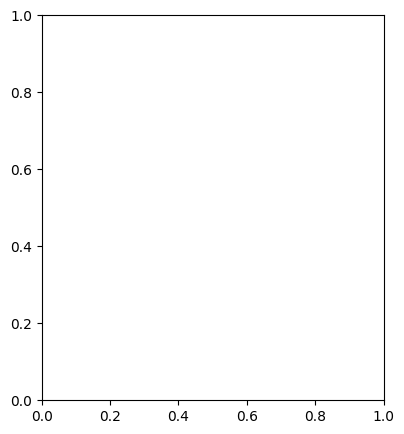

In [7]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Training Recon Loss')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Recon Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training KL Loss')
plt.plot(history.history['val_kl_loss'], label='Validation KL Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")

In [ ]:
# Evaluate the newly trained VAE
def get_kl_scores_new(encoder, data):
    z_mean, z_log_var, _ = encoder.predict(data, batch_size=1024)
    kl_loss = -0.5 * tf.reduce_mean(
        1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    )
    return kl_loss

print("Evaluating newly trained VAE...")

# Get scores for all datasets
score0_new = get_kl_scores_new(vae_new.encoder, X_test)
score2_new = get_kl_scores_new(vae_new.encoder, X_test2)
score3_new = get_kl_scores_new(vae_new.encoder, X_test3)
score4_new = get_kl_scores_new(vae_new.encoder, X_test4)

# Calculate metrics and store results
results["VAE NEW"] = {
    "scores": score0_new,
    "auc": roc_auc_score(dataset.test_labels, score0_new),
    "ap": average_precision_score(dataset.test_labels, score0_new),
    "time": vae_training_time,
}
results["VAE2 NEW"] = {
    "scores": score2_new,
    "auc": roc_auc_score(dataset2.test_labels, score2_new),
    "ap": average_precision_score(dataset2.test_labels, score2_new),
    "time": vae_training_time,
}
results["VAE3 NEW"] = {
    "scores": score3_new,
    "auc": roc_auc_score(dataset3.test_labels, score3_new),
    "ap": average_precision_score(dataset3.test_labels, score3_new),
    "time": vae_training_time,
}
results["VAE4 NEW"] = {
    "scores": score4_new,
    "auc": roc_auc_score(dataset4.test_labels, score4_new),
    "ap": average_precision_score(dataset4.test_labels, score4_new),
    "time": vae_training_time,
}

print("Newly trained VAE evaluation results:")
print(f"Dataset 1 (A->4l) - AUC: {results['VAE NEW']['auc']:.4f}, AP: {results['VAE NEW']['ap']:.4f}")
print(f"Dataset 2 (LQ->btau) - AUC: {results['VAE2 NEW']['auc']:.4f}, AP: {results['VAE2 NEW']['ap']:.4f}")
print(f"Dataset 3 (h0->tautau) - AUC: {results['VAE3 NEW']['auc']:.4f}, AP: {results['VAE3 NEW']['ap']:.4f}")
print(f"Dataset 4 (h+->taunu) - AUC: {results['VAE4 NEW']['auc']:.4f}, AP: {results['VAE4 NEW']['ap']:.4f}")

# Save the trained model
vae_new.save_weights('vae_new_final.weights.h5')
print("Saved final VAE model weights")

In [11]:
from fad.models.VAE_paper.models import dense_vae
from fad.models.VAE_paper.losses import make_kl
import tensorflow as tf

vae = dense_vae()
vae.build(input_shape=57)
vae.load_weights('/home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/vae.weights.h5')

encoder = vae.encoder

def get_kl_scores(encoder, data):
    z_mean, z_log_var, _ = encoder.predict(data)
    kl_loss = -0.5 * tf.reduce_mean(
        1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    )
    return kl_loss

score0 = get_kl_scores(encoder, X_test)
score2 = get_kl_scores(encoder, X_test2)
score3 = get_kl_scores(encoder, X_test3)
score4 = get_kl_scores(encoder, X_test4)

results["VAE"] = {
    "scores": score0,
    "auc": roc_auc_score(dataset.test_labels,   (score0)),
    "ap": average_precision_score(dataset.test_labels,   (score0)),
    "time": 0,
}
results["VAE2"] = {
    "scores":   (score2),
    "auc": roc_auc_score(dataset2.test_labels,   (score2)),
    "ap": average_precision_score(dataset2.test_labels,   (score2)),
    "time": 0,
}
results["VAE3"] = {
    "scores":   (score3),
    "auc": roc_auc_score(dataset3.test_labels,   (score3)),
    "ap": average_precision_score(dataset3.test_labels,   (score3)),
    "time": 0,
}
results["VAE4"] = {
    "scores":   (score4),
    "auc": roc_auc_score(dataset4.test_labels,   (score4)),
    "ap": average_precision_score(dataset4.test_labels,   (score4)),
    "time": 0,
}

2025-07-08 16:50:54.333111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 16:50:54.343025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751986254.353248   78137 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751986254.355930   78137 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751986254.368900   78137 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 57)        │        228 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 3)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,906 (11.35 KB)

 Trainable params: 2,696 (10.53 KB)

 Non-trainable params: 210 (840.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,585 (10.10 KB)

 Non-trainable params: 96 (384.00 B)

/home/fvaselli/miniconda3/envs/AD/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3625/3625 ━━━━━━━━━━━━━━━━━━━━ 2s 583us/step
3625/3625 ━━━━━━━━━━━━━━━━━━━━ 2s 583us/step
23142/23142 ━━━━━━━━━━━━━━━━━━━━ 11s 491us/step
23142/23142 ━━━━━━━━━━━━━━━━━━━━ 11s 491us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 20s 784us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 20s 784us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 18s 726us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 18s 726us/step


In [12]:

from fad.models.VAE_paper.models import Sampling
import json
from fad.models.VAE_paper.models import dense_vae
from fad.models.VAE_paper.losses import make_kl
import tensorflow as tf


def get_kl_scores(encoder, data):
    z_mean, z_log_var, _ = encoder.predict(data)
    kl_loss = -0.5 * tf.reduce_mean(
        1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    )
    return kl_loss

# Load the old VAE encoder model with proper custom objects
try:
    # First approach: Use tf.keras.utils.custom_object_scope
    with tf.keras.utils.custom_object_scope({'Sampling': Sampling}):
        encoder_old = tf.keras.models.load_model('/home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/VAE_models/VAE_encoder_notpruned.h5')
    print("Loaded old VAE encoder successfully using load_model")
except Exception as e:
    print(f"load_model failed: {e}")
    try:
        # Second approach: Manual JSON loading with more complete custom objects
        with open('/home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/VAE_models/VAE_encoder_notpruned.json', 'r') as json_file:
            json_config = json_file.read()
        
        # Include more custom objects that might be needed
        custom_objects = {
            'Sampling': Sampling,
            'Functional': tf.keras.Model,  # Map Functional to the base Model class
        }
        
        encoder_old = tf.keras.models.model_from_json(json_config, custom_objects=custom_objects)
        encoder_old.load_weights('/home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/VAE_models/VAE_encoder_notpruned.h5')
        print("Loaded old VAE encoder successfully using model_from_json")
    except Exception as e2:
        print(f"model_from_json also failed: {e2}")
        try:
            # Third approach: Try loading without custom objects first
            with open('/home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/VAE_models/VAE_encoder_notpruned.json', 'r') as json_file:
                config_dict = json.load(json_file)
            
            # Manually create the model from config
            encoder_old = tf.keras.Model.from_config(config_dict['config'], custom_objects={'Sampling': Sampling})
            encoder_old.load_weights('/home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/VAE_models/VAE_encoder_notpruned.h5')
            print("Loaded old VAE encoder successfully using Model.from_config")
        except Exception as e3:
            print(f"All loading methods failed. Final error: {e3}")
            # Fallback: Skip the old model evaluation
            encoder_old = None

if encoder_old is not None:
    print(f"Old encoder input shape: {encoder_old.input_shape}")
    print(f"Old encoder output shapes: {[output.shape for output in encoder_old.outputs]}")

    # Calculate KL scores for all datasets using the old model
    score0_old = get_kl_scores(encoder_old, X_test)
    score2_old = get_kl_scores(encoder_old, X_test2)
    score3_old = get_kl_scores(encoder_old, X_test3)
    score4_old = get_kl_scores(encoder_old, X_test4)

    results["VAE old"] = {
        "scores": score0_old,
        "auc": roc_auc_score(dataset.test_labels, score0_old),
        "ap": average_precision_score(dataset.test_labels, score0_old),
        "time": 0,
    }
    results["VAE2 old"] = {
        "scores": score2_old,
        "auc": roc_auc_score(dataset2.test_labels, score2_old),
        "ap": average_precision_score(dataset2.test_labels, score2_old),
        "time": 0,
    }
    results["VAE3 old"] = {
        "scores": score3_old,
        "auc": roc_auc_score(dataset3.test_labels, score3_old),
        "ap": average_precision_score(dataset3.test_labels, score3_old),
        "time": 0,
    }
    results["VAE4 old"] = {
        "scores": score4_old,
        "auc": roc_auc_score(dataset4.test_labels, score4_old),
        "ap": average_precision_score(dataset4.test_labels, score4_old),
        "time": 0,
    }

    print("Old VAE model evaluation completed")
    print(f"AUC scores - Dataset 1: {results['VAE old']['auc']:.4f}, Dataset 2: {results['VAE2 old']['auc']:.4f}")
else:
    print("Skipping old VAE model evaluation due to loading issues")

load_model failed: No model config found in the file at /home/fvaselli/Documents/PHD/fAD/fad/models/VAE_paper/VAE_models/VAE_encoder_notpruned.h5.
Loaded old VAE encoder successfully using model_from_json
Old encoder input shape: (None, 57)
Old encoder output shapes: [(None, 3), (None, 3), (None, 3)]
   1/3625 ━━━━━━━━━━━━━━━━━━━━ 7:09 119ms/step

/home/fvaselli/miniconda3/envs/AD/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3625/3625 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step
3625/3625 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step
23142/23142 ━━━━━━━━━━━━━━━━━━━━ 17s 746us/step
23142/23142 ━━━━━━━━━━━━━━━━━━━━ 17s 746us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 19s 739us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 19s 739us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 13s 536us/step
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 13s 536us/step
Old VAE model evaluation completed
AUC scores - Dataset 1: 0.8884, Dataset 2: 0.8147
Old VAE model evaluation completed
AUC scores - Dataset 1: 0.8884, Dataset 2: 0.8147


In [12]:
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2 vt einsum"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}
# now again in ODE mode
flow_scores2 = flow_matching.predict(
    X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 100)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
results["Flow Matching2 ode"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

Mean score for normal samples: 72.6531
Std score for normal samples: 41.7654
Mean score for anomalous samples: 112.5425
Std score for anomalous samples: 68.7454
Accuracy: 0.4599
AUC-ROC: 0.7581
Average Precision: 0.6998
Mean score for normal samples: 7022.8296
Std score for normal samples: 17857.6055
Mean score for anomalous samples: 17391.7422
Std score for anomalous samples: 38603.9258
Accuracy: 0.4599
AUC-ROC: 0.7581
Average Precision: 0.6998
time grid: tensor([1., 0.])
Mean score for normal samples: 156.7291
Std score for normal samples: 861.0925
Mean score for anomalous samples: 386.4001
Std score for anomalous samples: 1864.6407
Accuracy: 0.7198
AUC-ROC: 0.7827
Average Precision: 0.7267


In [13]:
# Predict anomaly scores
flow_scores3 = flow_matching.predict(X_test3, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")
results["Flow Matching3 vt"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "time": 1,
}

# Predict anomaly scores
flow_scores3 = flow_matching.predict(X_test3, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")

results["Flow Matching3 vt einsum"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "time": 1,
}
# now again in ODE mode
flow_scores3 = flow_matching.predict(
    X_test3, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 100)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")
results["Flow Matching3 ode"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "time": 1,
}

Mean score for normal samples: 72.6531
Std score for normal samples: 41.7654
Mean score for anomalous samples: 116.9236
Std score for anomalous samples: 99.5424
Accuracy: 0.5000
AUC-ROC: 0.6653
Average Precision: 0.7024
Mean score for normal samples: 7022.8296
Std score for normal samples: 17857.6055
Mean score for anomalous samples: 23579.8125
Std score for anomalous samples: 75606.6953
Accuracy: 0.5000
AUC-ROC: 0.6653
Average Precision: 0.7024
time grid: tensor([1., 0.])
Mean score for normal samples: 156.7257
Std score for normal samples: 861.1056
Mean score for anomalous samples: 673.7747
Std score for anomalous samples: 5053.0396
Accuracy: 0.6396
AUC-ROC: 0.6740
Average Precision: 0.7048


In [14]:
# Predict anomaly scores
flow_scores4 = flow_matching.predict(X_test4, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")

results["Flow Matching4 vt"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "time": 1,
}

# Predict anomaly scores
flow_scores4 = flow_matching.predict(X_test4, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")

results["Flow Matching4 vt einsum"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "time": 1,
}
# now again in ODE mode
flow_scores4 = flow_matching.predict(
    X_test4, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 100)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")
results["Flow Matching4 ode"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "time": 1,
}

Mean score for normal samples: 72.6531
Std score for normal samples: 41.7654
Mean score for anomalous samples: 190.3779
Std score for anomalous samples: 144.0108
Accuracy: 0.5000
AUC-ROC: 0.9062
Average Precision: 0.8984
Mean score for normal samples: 7022.8296
Std score for normal samples: 17857.6055
Mean score for anomalous samples: 56982.8555
Std score for anomalous samples: 159476.4219
Accuracy: 0.5000
AUC-ROC: 0.9062
Average Precision: 0.8984
time grid: tensor([1., 0.])
Mean score for normal samples: 156.7245
Std score for normal samples: 861.1011
Mean score for anomalous samples: 1925.0072
Std score for anomalous samples: 11526.0273
Accuracy: 0.7744
AUC-ROC: 0.8833
Average Precision: 0.8838


## 5. Model Comparison and Visualization

Isolation Forest
Flow Matching vt
Flow Matching vt einsum
Flow Matching ode
Flow Matching2 vt
Flow Matching2 vt einsum
Flow Matching2 ode
Flow Matching3 vt
Flow Matching3 vt einsum
Flow Matching3 ode
Flow Matching4 vt
Flow Matching4 vt einsum
Flow Matching4 ode


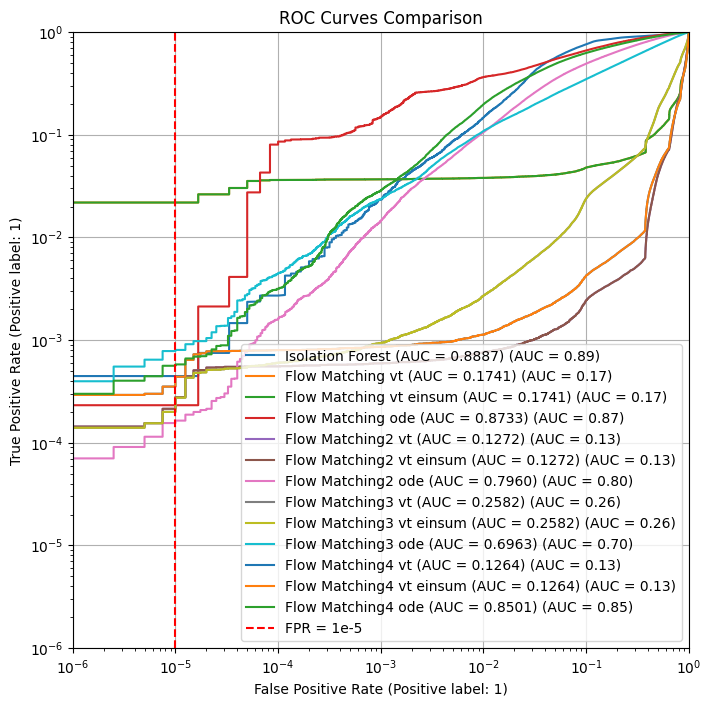

/home/fvaselli/miniconda3/envs/AD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


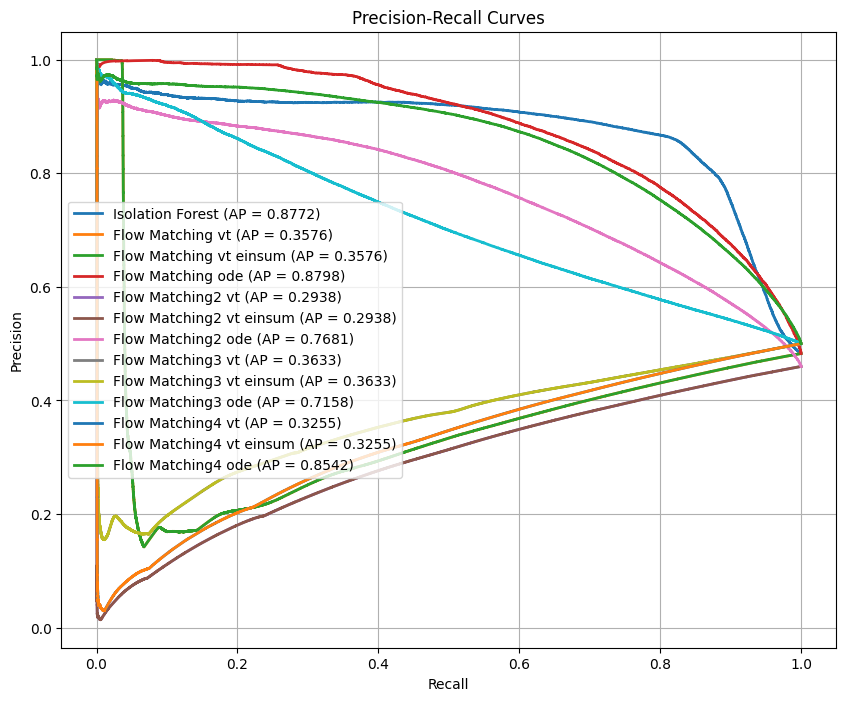

In [ ]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    print(name)
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 vt einsum") | (name == "Flow Matching2 ode") | (name == "VAE2 old") | (name == "VAE2 NEW"):
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name == "Flow Matching3 vt") | (name == "Flow Matching3 vt einsum") | (name == "Flow Matching3 ode") | (name == "VAE3 old") | (name == "VAE3 NEW"):
        # use the third dataset for this model
        RocCurveDisplay.from_predictions(
            dataset3.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    elif (name == "Flow Matching4 vt") | (name == "Flow Matching4 vt einsum") | (name == "Flow Matching4 ode") | (name == "VAE4 old") | (name == "VAE4 NEW"):
        # use the fourth dataset for this model
        RocCurveDisplay.from_predictions(
            dataset4.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if (name == "Flow Matching2 vt") | (name == "Flow Matching2 vt einsum") | (name == "Flow Matching2 ode") | (name == "VAE2 old") | (name == "VAE2 NEW"):
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name == "Flow Matching3 vt") | (name == "Flow Matching3 vt einsum") | (name == "Flow Matching3 ode") | (name == "VAE3 old") | (name == "VAE3 NEW"):
        # use the third dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset3.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    elif (name == "Flow Matching4 vt") | (name == "Flow Matching4 vt einsum") | (name == "Flow Matching4 ode") | (name == "VAE4 old") | (name == "VAE4 NEW"):
        # use the fourth dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset4.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

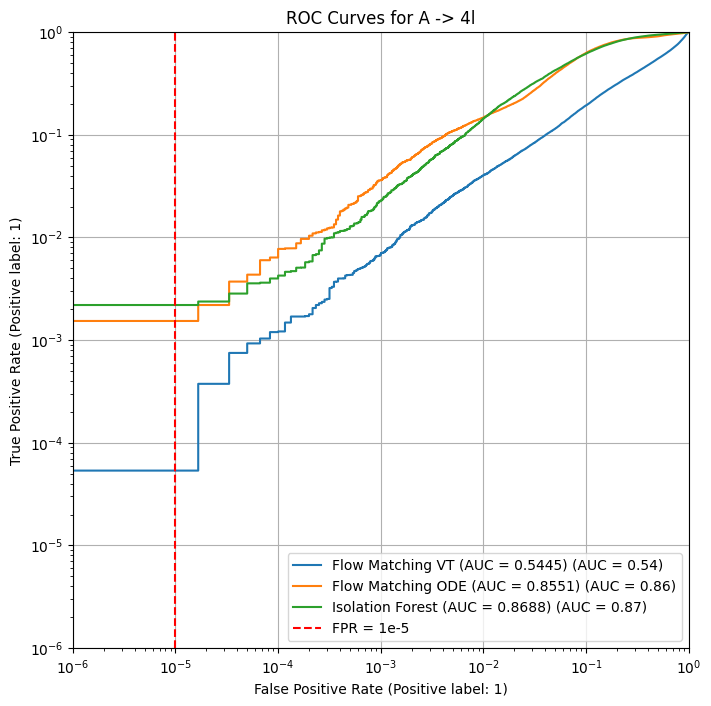

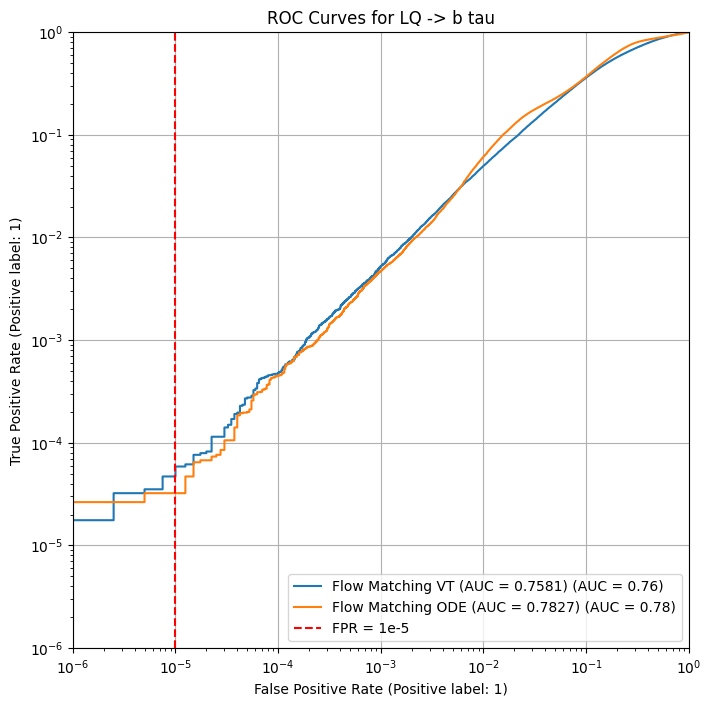

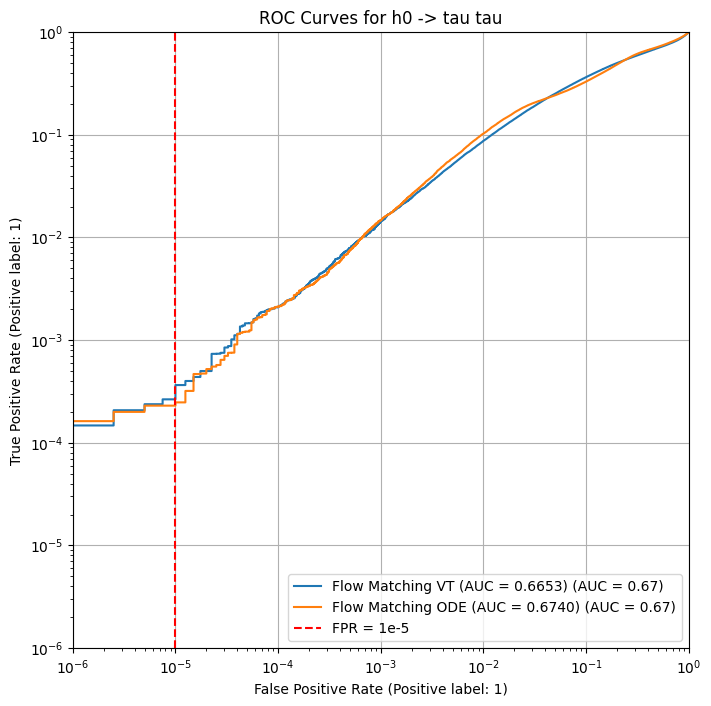

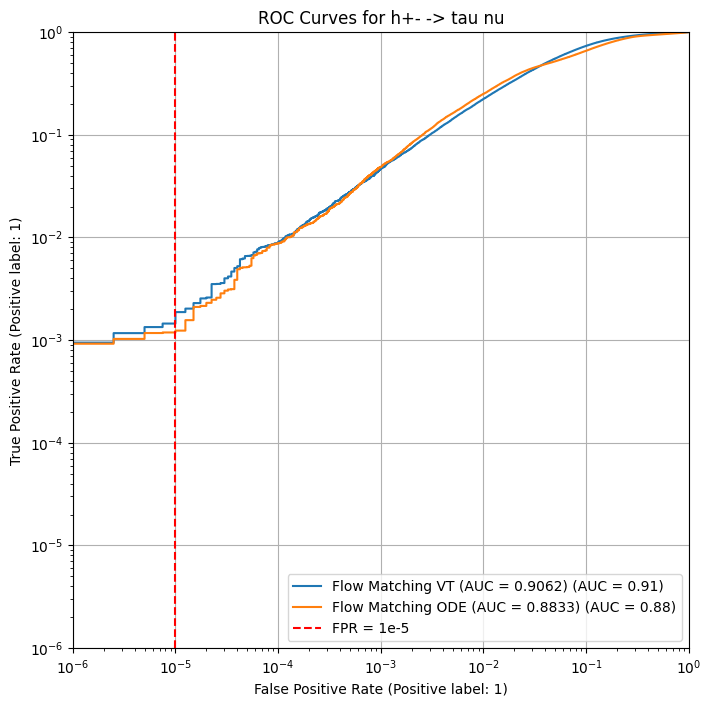

In [ ]:
# Define dataset names and corresponding results prefixes/labels
dataset_info = [
    {"name": "A -> 4l", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt", "suffix_ode": "ode", "vae_key": "VAE",  "old_vae_key": "VAE", "new_vae_key": "VAE NEW"},
    {"name": "LQ -> b tau", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt", "suffix_ode": "ode", "vae_key": "VAE2", "old_vae_key": "VAE2 old", "new_vae_key": "VAE2 NEW"},
    {"name": "h0 -> tau tau", "prefix": "Flow Matching3 ", "labels": dataset3.test_labels, "suffix_vt": "vt", "suffix_ode": "ode", "vae_key": "VAE3", "old_vae_key": "VAE3 old", "new_vae_key": "VAE3 NEW"},
    {"name": "h+- -> tau nu", "prefix": "Flow Matching4 ", "labels": dataset4.test_labels, "suffix_vt": "vt", "suffix_ode": "ode", "vae_key": "VAE4", "old_vae_key": "VAE4 old", "new_vae_key": "VAE4 NEW"},
]

for info in dataset_info:
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    dataset_name = info["name"]
    prefix = info["prefix"]
    labels = info["labels"]
    
    # Plot vt mode
    vt_key = prefix + info["suffix_vt"]
    if vt_key in results:
        result_vt = results[vt_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vt["scores"],
            name=f"Flow Matching VT (AUC = {result_vt['auc']:.4f})",
            ax=ax,
        )
    
    # Plot ode mode
    ode_key = prefix + info["suffix_ode"]
    if ode_key in results:
        result_ode = results[ode_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_ode["scores"],
            name=f"Flow Matching ODE (AUC = {result_ode['auc']:.4f})",
            ax=ax,
        )
        
    # Plot VAE results
    vae_key = info["vae_key"]
    if vae_key in results:
        result_vae = results[vae_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vae["scores"],
            name=f"VAE Katya(AUC = {result_vae['auc']:.4f})",
            ax=ax,
        )

    old_vae_key = info["old_vae_key"]
    if old_vae_key in results:
        result_vae = results[old_vae_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vae["scores"],
            name=f"VAE OLD(AUC = {result_vae['auc']:.4f})",
            ax=ax,
        )

    # Plot newly trained VAE results
    new_vae_key = info["new_vae_key"]
    if new_vae_key in results:
        result_vae_new = results[new_vae_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vae_new["scores"],
            name=f"VAE NEW(AUC = {result_vae_new['auc']:.4f})",
            ax=ax,
        )
        
    # Add Isolation Forest for the first dataset for comparison
    if dataset_name == "A -> 4l" and "Isolation Forest" in results:
         result_iso = results["Isolation Forest"]
         RocCurveDisplay.from_predictions(
             labels,
             result_iso["scores"],
             name=f"Isolation Forest (AUC = {result_iso['auc']:.4f})",
             ax=ax,
         )

    plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([1e-6, 1])
    plt.ylim([1e-6, 1])
    plt.title(f"ROC Curves for {dataset_name}")
    plt.grid(True)
    plt.legend()
    plt.show()

## 6. Score Distributions

In [ ]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    if name != "Flow Matching":
        continue
    plt.subplot(1, 1, 1)

    # Separate scores for normal and anomaly classes
    if name == "Flow Matching2":
        # use the second dataset for this model
        normal_scores = result["scores"][dataset2.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset2.test_labels == 1]
    else:
        normal_scores = result["scores"][dataset.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

torch.Size([2, 5, 57])
torch.Size([2, 5, 57])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

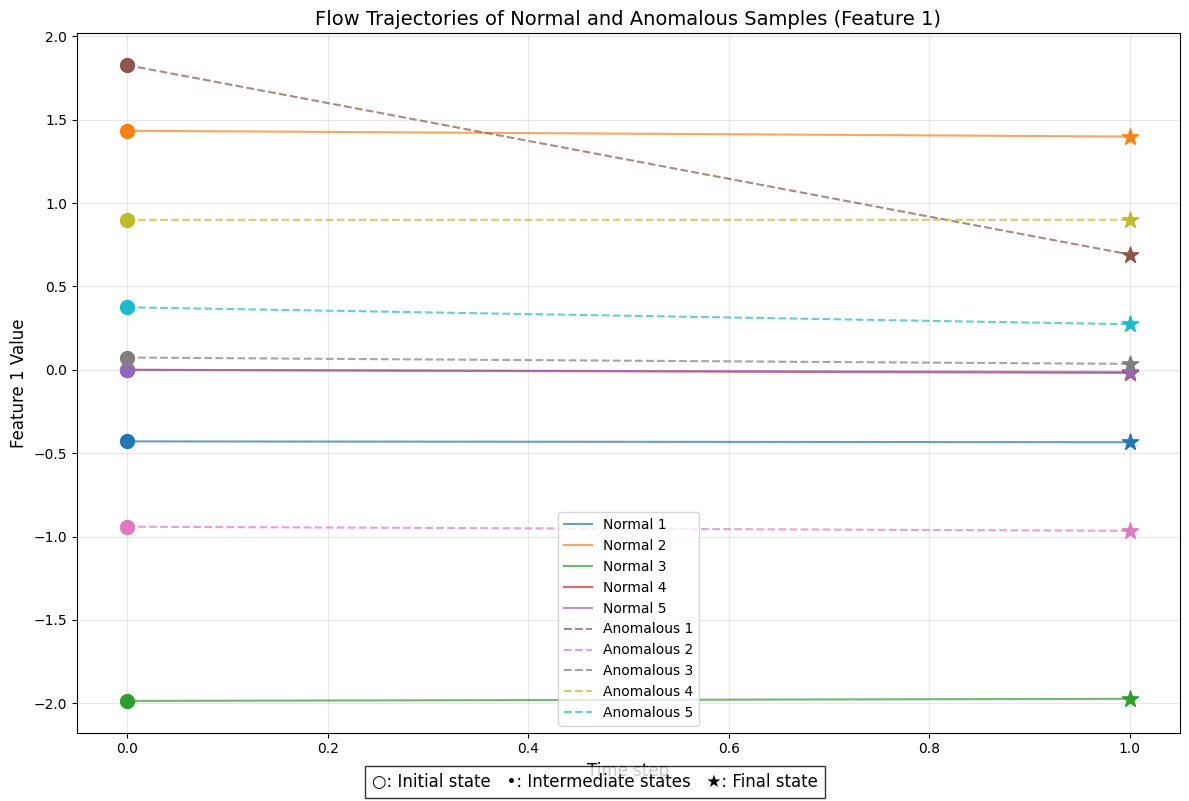

In [ ]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i + 1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i}",
        s=150,
        zorder=10,
    )

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(
        trajectory[:, 4],
        label=f"Anomalous {i + 1}",
        linestyle="--",
        color=f"C{i + 5}",
        alpha=0.7,
    )
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i + 5}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i + 5}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i + 5}",
        s=150,
        zorder=10,
    )

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(
    0.5,
    0.01,
    "○: Initial state   •: Intermediate states   ★: Final state",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

## 7. Results Summary

In [ ]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8711     0.8516          26.29          
Flow Matching vt     0.8663     0.8727          1.00           
Flow Matching vt einsum 0.8663     0.8727          1.00           
Flow Matching ode    0.8680     0.8726          1.00           
Flow Matching2 vt    0.7979     0.7636          1.00           
Flow Matching2 vt einsum 0.7979     0.7636          1.00           
Flow Matching2 ode   0.7945     0.7626          1.00           
Flow Matching3 vt    0.6611     0.6891          1.00           
Flow Matching3 vt einsum 0.6611     0.6891          1.00           
Flow Matching3 ode   0.6856     0.7038          1.00           
Flow Matching4 vt    0.8484     0.8366          1.00           
Flow Matching4 vt einsum 0.8484     0.8366          1.00           
Flow Matching4 ode   0.8547     0.8481          1.00         